In [2]:
import os
import regex
import math
import csv
from collections import Counter, OrderedDict
from functools import reduce
from operator import add

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from scipy import spatial
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from tqdm.notebook import tqdm

# Пункт 1. Чтение данных и построение матрицы Term-Document

In [3]:
stop_words = set(stopwords.words('english'))
emotiocons = r'(?:(?::|;|=)(?:-|_)?(?:\)|\(|D|P))|(?:[-*]_[-*])'
ending_signs = r'(?:\?|\.|\.\.\.|\!|\?\!|\!\?)$'

def read_data(subset="train", squeeze_text=True, collect_analysis=True):

    # if squeeze_text=True, then we won't split text by sentences and each text will consist with one array of tokens
    # if squeeze_text=False, then wil be created corpus of all sentences
    
    token_frequency = Counter()
    term_document_matrix = Counter()
    term_document_matrix_v2 = dict()
    
    texts = dict()
    
    # Перебираем папки
    for folder in tqdm(['age', 'ethnicity', 'gender', 'religion', 'other_cyberbullying', 'not_cyberbullying']):
        # Путь к папке
        folder_path = os.path.join(f'../assets/annotated-corpus/', subset, folder)
        # Перебираем файлы в папке
        for file in tqdm(os.listdir(folder_path)):
            # Если это tsv файл
            if file.endswith('.tsv'):
                # Путь к файлу
                file_path = os.path.join(folder_path, file)
                # Читаем файл
                try: 
                    df = pd.read_csv(file_path, sep='\t', header=None)
                except pd.errors.EmptyDataError:
                    continue
                    
                # Группируем токены по предложениям (предполагает, что предложение отделено пустой строкой)
                text = list()
                sentence = list()
                tokens_list = df[0].tolist()
                for token in tokens_list:
                    token = str(token).lower()
                    if (regex.search(emotiocons, token) is None and regex.search(ending_signs, token) is not None) \
                        or token in stop_words:
                        continue
                    
                    if squeeze_text:
                        if token == 'nan':
                            continue
                        text.append(token)
                    else:
                        if token == 'nan':
                            if len(sentence) > 0:
                                text.append(sentence)
                            sentence = []
                            continue
                        else:
                            sentence.append(token)
                    
                    if collect_analysis:
                        token_frequency[token] += 1
                        doc_name = f"{folder}_{file.rsplit('.', 1)[0]}"
                        term_document_matrix[(token, doc_name)] += 1
                        if token not in term_document_matrix_v2:
                            term_document_matrix_v2[token] = { doc_name: 1 }
                        else:
                            if doc_name not in term_document_matrix_v2[token]:
                                term_document_matrix_v2[token][doc_name] = 1
                            else:
                                term_document_matrix_v2[token][doc_name] += 1
                
                if not squeeze_text and len(sentence) > 0:
                    text.append(sentence)
                
                if len(text) > 0:
                    texts[f"{folder}_{file.rsplit('.', 1)[0]}"] = text
                    
    return texts, token_frequency, term_document_matrix, term_document_matrix_v2

In [4]:
train_texts, token_frequency, term_document_matrix, term_document_matrix_v2 = read_data("train", True, True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6024 [00:00<?, ?it/s]

  0%|          | 0/5941 [00:00<?, ?it/s]

  0%|          | 0/6029 [00:00<?, ?it/s]

  0%|          | 0/6021 [00:00<?, ?it/s]

  0%|          | 0/5851 [00:00<?, ?it/s]

  0%|          | 0/5876 [00:00<?, ?it/s]

In [5]:
test_texts, _, _, _ = read_data("test", True, False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1968 [00:00<?, ?it/s]

  0%|          | 0/2018 [00:00<?, ?it/s]

  0%|          | 0/1919 [00:00<?, ?it/s]

  0%|          | 0/1976 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

  0%|          | 0/2061 [00:00<?, ?it/s]

# Пункт 2. Построение матрицы TD-IDF

### Чистим данные от редких токенов

In [6]:
token_frequency_copy = token_frequency.copy()

In [7]:
for k, v in token_frequency.items():
    if v < 2:
        del token_frequency_copy[k]

In [8]:
# Находим токены, которые встречаются 1 раз
rare_tokens = dict(filter(lambda x: x[1] < 2, token_frequency.items())).keys()

In [10]:
len(token_frequency), len(token_frequency) - len(rare_tokens)

(52603, 20015)

In [11]:
term_document_matrix_copy_v2 = term_document_matrix_v2.copy()

In [12]:
for k, v in term_document_matrix_v2.items():
    if k in rare_tokens:
        del term_document_matrix_copy_v2[k]

In [13]:
len(term_document_matrix_v2), len(term_document_matrix_copy_v2)

(52603, 20015)

### Строим матрицу Document-Term

In [14]:
document_term_matrix_v2  = dict()

for term, v in term_document_matrix_copy_v2.items():
    for doc, val in v.items():
        if doc not in document_term_matrix_v2:
            document_term_matrix_v2[doc] = { term: val }
        else:
            document_term_matrix_v2[doc][term] = val

In [15]:
len(dict(filter(lambda x: len(x[1]) > 1, document_term_matrix_v2.items())))

35095

In [16]:
len(dict(filter(lambda x: len(x[1]) > 1, term_document_matrix_v2.items())))

19521

### Строим матрицу TF-IDF

In [12]:
td_matrix = term_document_matrix_copy_v2
dt_matrix = document_term_matrix_v2

documents = dt_matrix.keys()
n = len(dt_matrix)

tf_idf = dict()

for doc, term_vals in dt_matrix.items():
    temp_calc = dict()
    for term, val in term_vals.items():
        tf = val / sum(term_vals.values())
        idf = math.log(n / len(td_matrix[term].keys()))
        temp_calc[term] = tf * idf
    tf_idf[doc] = temp_calc

#  Пункт 3
Реализовать метод, позволяющий векторизовать произвольный текст с использованием нейронных сетей (предлагается использовать стандартную реализацию модели w2v или glove). Выбранную модель необходимо обучить на обучающей выборке.

In [14]:
pure_texts = list(train_texts.values())
model = Word2Vec(sentences=pure_texts, vector_size=100, window=3, min_count=1, workers=4)

In [15]:
model.train(pure_texts, total_examples=len(pure_texts), epochs=100)

(45816036, 49273600)

In [9]:
#token_frequency

In [16]:
vector1 = model.wv['black']
vector2 = model.wv['white']

vector3 = model.wv['fuck']
vector4 = model.wv['dumb']
vector5 = model.wv['bitch']
vector6 = model.wv['idiot']
vector7 = model.wv['stupid']

vector8 = model.wv['people']
vector9 = model.wv['girl']
vector10 = model.wv['woman']
vector11 = model.wv['man']

vector12 = model.wv['islam']
vector13 = model.wv['muslim']
vector14 = model.wv['christian']

# Пункт 4

Рассмотрим насколько близки между собой токены, выбранные в 3 пункте.

In [18]:
def cosine_sim_lib(vec1, vec2):
    return 1 - spatial.distance.cosine(vec1, vec2)

In [19]:
def cosine_sim(vec1, vec2):
    assert len(vec1) == len(vec2) and not isinstance(vec1[0], list)
    dot12, norm1, norm2 = 0, 0, 0
    for x1, x2 in zip(vec1, vec2):
        dot12 += x1 * x2
        norm1 += x1 * x1
        norm2 += x2 * x2
    return dot12 / math.sqrt(norm1 * norm2)

In [20]:
cosine_sim(vector1, vector2), cosine_sim_lib(vector1, vector2)

(0.6877299085862061, 0.6877298355102539)

In [21]:
words = list(model.wv.key_to_index)
X = [model.wv[word] for word in words]

In [22]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

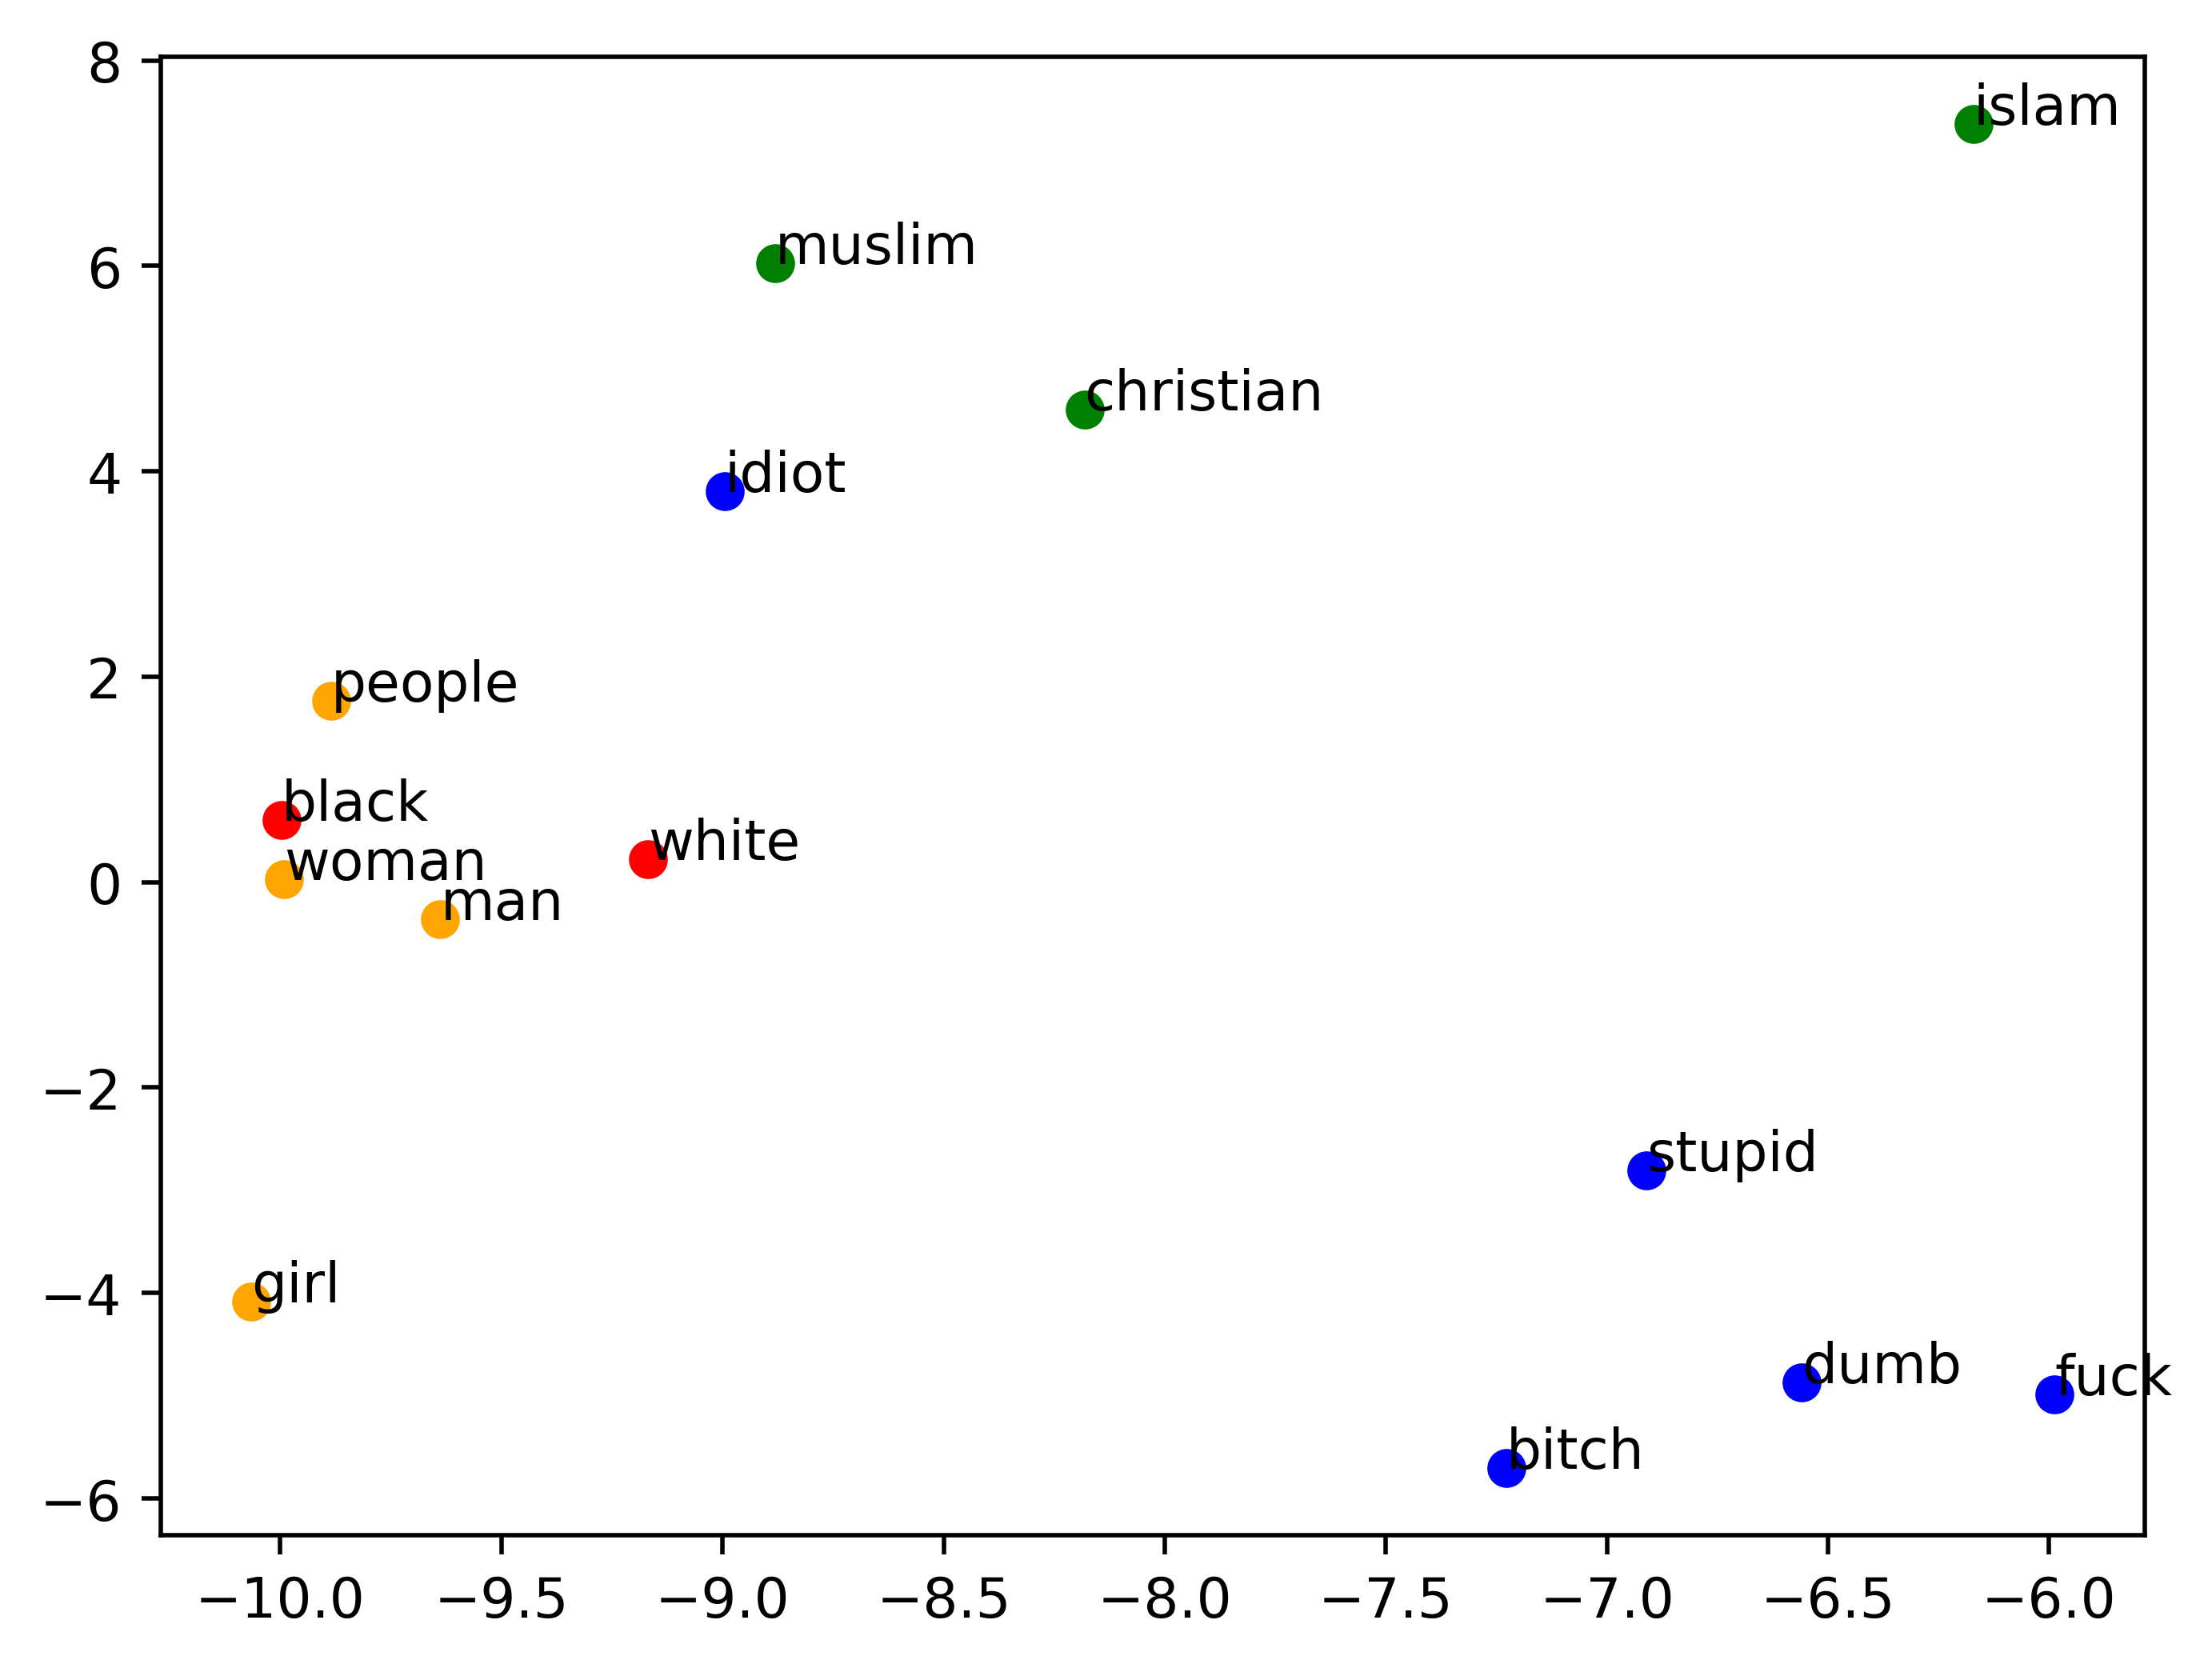

In [23]:
plt.figure(dpi=500)

for vec, name in zip([vector1, vector2],['black', 'white']):
    reduced_vec = pca.transform(vec[np.newaxis, ...])
    plt.plot(reduced_vec[0][0], reduced_vec[0][1], 'o', color='red')
    plt.annotate(name, (reduced_vec[0][0], reduced_vec[0][1]))

for vec, name in zip([vector3, vector4, vector5, vector6, vector7], ['fuck', 'dumb', 'bitch', 'idiot', 'stupid']):
    reduced_vec = pca.transform(vec[np.newaxis, ...])
    plt.plot(reduced_vec[0][0], reduced_vec[0][1], 'o', color='blue')
    plt.annotate(name, (reduced_vec[0][0], reduced_vec[0][1]))
    
for vec, name in zip([vector8, vector9, vector10, vector11], ['people', 'girl', 'woman', 'man']):
    reduced_vec = pca.transform(vec[np.newaxis, ...])
    plt.plot(reduced_vec[0][0], reduced_vec[0][1], 'o', color='orange')
    plt.annotate(name, (reduced_vec[0][0], reduced_vec[0][1]))
    
for vec, name in zip([vector12, vector13, vector14], ['islam', 'muslim', 'christian']):
    reduced_vec = pca.transform(vec[np.newaxis, ...])
    plt.plot(reduced_vec[0][0], reduced_vec[0][1], 'o', color='green')
    plt.annotate(name, (reduced_vec[0][0], reduced_vec[0][1]))

plt.show()

# Пункт 5
Сократим размерность матрицы TF-IDF. Для этого преобразуем её из эффективного формата хранения в разреженную матрицу

In [81]:
len(list(td_matrix))

20015

In [24]:
terms = list(td_matrix)
docs = list(dt_matrix)

In [25]:
sparse_data = np.full((len(docs), len(terms)), 0, dtype=np.float32)

In [26]:
for i, doc in tqdm(enumerate(docs)):
    for j, term in enumerate(terms):
        if term in tf_idf[doc]:
            sparse_data[i, j] = tf_idf[doc][term]

0it [00:00, ?it/s]

In [27]:
sparse_data

array([[0.55306715, 0.33864695, 0.52458876, ..., 0.        , 0.        ,
        0.        ],
       [0.21069226, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16387175, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [28]:
pca_v2 = PCA(n_components=100)
sparse_pca_data = pca_v2.fit_transform(sparse_data)

# Пункт 6
С использованием разработанного метода подсчета косинусного расстояния сравнить эффективность метода векторизации с использованием нейронных сетей и эффективность базовых методов векторизации с последующим сокращением размерности.

In [144]:
tf_idf[docs[500]].keys()

dict_keys(['one', 'school', 'bully', 'bullies', 'called', 'got', 'grade', 'calling', 'middle', 'often', 'think', 'worst', 'absolutely', 'fragile', 'mom', 'gorilla', 'freak', 'assembly', 'sensitive'])

In [29]:
model_data = np.full((len(docs), 100), 0, dtype=np.float32)
for i, doc in enumerate(docs):
    temp = np.full(100, 0, dtype=np.float32)
    cnt = 0
    for word in tf_idf[doc].keys():
        temp += model.wv[word]
        cnt += 1 
    model_data[i] = temp / cnt

In [30]:
top_words_v1 = dict(sorted(token_frequency.items(), key=lambda x: x[1], reverse=True)[:100])

In [32]:
top_words_v2 = { k: v for k, v in token_frequency.items() if v > 200 }

In [33]:
len(top_words_v2)

347

Подберём тексты, содержащие популярные слова, при этом с разной меткой и минимальным числом слов 5

In [34]:
def is_doc_valid(doc_name, words, category, num_words, must_words):
    return category in doc_name and len(words) >= num_words and len(words.intersection(must_words)) > 0

In [35]:
docs_subset = list()
texts_cnt = {
    'age': 0, 'ethnicity': 0, 'gender': 0, 'religion': 0, 'other_cyberbullying': 0, 'not_cyberbullying': 0
}
num_words = 5
num_docs_per_category = 3

must_words = set(top_words_v1)
for doc, words in dt_matrix.items():
    ws = set(words.keys())
    for category in texts_cnt.keys():
        if texts_cnt[category] < num_docs_per_category and is_doc_valid(doc, ws, category, num_words, must_words):
            texts_cnt[category] += 1
            docs_subset.append(doc)
            break

In [36]:
docs_subset

['age_11616',
 'age_10468',
 'age_19302',
 'ethnicity_16151',
 'ethnicity_24336',
 'ethnicity_20965',
 'gender_17267',
 'gender_23868',
 'gender_10534',
 'religion_25570',
 'religion_7335',
 'religion_34092',
 'other_cyberbullying_18008',
 'other_cyberbullying_9291',
 'other_cyberbullying_22619',
 'not_cyberbullying_20594',
 'not_cyberbullying_30989',
 'not_cyberbullying_365']

In [37]:
base_doc = docs_subset[0]
base_index = docs.index(base_doc)
for doc in docs_subset:
    index = docs.index(doc)
    print(f"Words2Vec: {base_doc} <-> {doc}:", cosine_sim(model_data[base_index], model_data[index]))
    print(f"TF-IDF: {base_doc} <-> {doc}:", cosine_sim(sparse_data[base_index], sparse_data[index]))
    print(f"TF-IDF with PCA: {base_doc} <-> {doc}:", cosine_sim(sparse_pca_data[base_index], sparse_pca_data[index]))
    print()

Words2Vec: age_11616 <-> age_11616: 1.0
TF-IDF: age_11616 <-> age_11616: 1.0
TF-IDF with PCA: age_11616 <-> age_11616: 1.0

Words2Vec: age_11616 <-> age_10468: 0.8289028851209419
TF-IDF: age_11616 <-> age_10468: 0.06144195056264724
TF-IDF with PCA: age_11616 <-> age_10468: 0.004959522116622067

Words2Vec: age_11616 <-> age_19302: 0.8543948737448885
TF-IDF: age_11616 <-> age_19302: 0.08479716877827968
TF-IDF with PCA: age_11616 <-> age_19302: 0.3300643829931652

Words2Vec: age_11616 <-> ethnicity_16151: 0.6536122302441175
TF-IDF: age_11616 <-> ethnicity_16151: 0.09267814258963003
TF-IDF with PCA: age_11616 <-> ethnicity_16151: -0.10798980979802296

Words2Vec: age_11616 <-> ethnicity_24336: 0.7397720614041581
TF-IDF: age_11616 <-> ethnicity_24336: 0.05054347004972796
TF-IDF with PCA: age_11616 <-> ethnicity_24336: -0.12682254362385034

Words2Vec: age_11616 <-> ethnicity_20965: 0.6944009038244539
TF-IDF: age_11616 <-> ethnicity_20965: 0.05219893775532761
TF-IDF with PCA: age_11616 <-> eth

# Пункт 7
Реализовать метод, осуществляющий векторизацию произвольного текста

In [38]:
def inverse_td_matrix(td_matrix):
    dt_matrix  = dict()

    for term, v in td_matrix.items():
        for doc, val in v.items():
            if doc not in dt_matrix:
                dt_matrix[doc] = { term: val }
            else:
                dt_matrix[doc][term] = val
    return dt_matrix

In [39]:
def calc_tf_idf(td_matrix, dt_matrix):
    n = len(dt_matrix)  
    tf_idf = dict()
    
    for doc, term_vals in tqdm(dt_matrix.items()):
        temp_calc = dict()
        for term, val in term_vals.items():
            tf = val / sum(term_vals.values())
            idf = math.log(n / len(td_matrix[term].keys()))
            temp_calc[term] = tf * idf
        tf_idf[doc] = temp_calc
    return tf_idf

In [40]:
def clear_texts(texts, rare_tokens):
    texts_copy = OrderedDict()
    for key, text in tqdm(texts.items()):
        text_copy = list()
        for sentence in text:
            sentence_copy = list()
            for word in sentence:
                if word not in rare_tokens:
                    sentence_copy.append(word)
            if len(sentence_copy) > 0:
                text_copy.append(sentence_copy)
        if len(text_copy) > 0:
            texts_copy[key] = text_copy
    return texts_copy

In [41]:
def vectorize_texts(subset, clear_rare_tokens=True):
    print("Reading data and calculating term-document matrices")
    texts, token_frequency_base, term_document_matrix, td_matrix_base = read_data(subset, False, True)

    texts = OrderedDict(texts)

    if clear_rare_tokens:
        print("Delete rare tokens in token_frequency")
        rare_tokens = dict(filter(lambda x: x[1] < 2, token_frequency.items())).keys()

        print("Delete rare tokens in term-document matrix")
        td_matrix = td_matrix_base.copy()
        for k, v in td_matrix_base.items():
            if k in rare_tokens:
                del td_matrix[k]

        print("Clear texts")
        texts = clear_texts(texts, rare_tokens)

    else:
        td_matrix = td_matrix_base

    print("Build document-term matrix")
    dt_matrix = inverse_td_matrix(td_matrix)

    print("Calculate TF-IDF")
    tf_idf = calc_tf_idf(td_matrix, dt_matrix)

    pure_texts = list(map(lambda x: reduce(add, x), texts.values()))

    print("Train Word2Vec")
    model = Word2Vec(sentences=pure_texts, vector_size=100, window=3, min_count=1, workers=4)
    model.train(pure_texts, total_examples=len(pure_texts), epochs=100)

    print("Vectorize texts")
    model_data = np.full((len(dt_matrix), 100), 0, dtype=np.float32)
    for i, (doc, sentences) in tqdm(enumerate(texts.items())):
        temp = np.empty((0, 100), dtype=np.float32)
        cnt = 0
        for sentence in sentences:
            sentence_vec = np.full(100, 0, dtype=np.float32)
            for word in sentence:
                sentence_vec += model.wv[word] * tf_idf[doc][word]
            temp = np.vstack((temp, sentence_vec / sum(tf_idf[doc].values())))

        model_data[i] = np.mean(temp, axis=0)

    return texts, model_data

# Пункт 8
Выполнить векторизацию тестовой выборки с использованием метода, реализованного на предыдущем шаге. Результаты сохранить в формате tsv 

In [43]:
texts, test_vecs = vectorize_texts("test", clear_rare_tokens=True)

Reading data and calculating term-document matrices


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1968 [00:00<?, ?it/s]

  0%|          | 0/2018 [00:00<?, ?it/s]

  0%|          | 0/1919 [00:00<?, ?it/s]

  0%|          | 0/1976 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

  0%|          | 0/2061 [00:00<?, ?it/s]

Delete rare tokens in token_frequency
Delete rare tokens in term-document matrix
Clear texts


  0%|          | 0/11911 [00:00<?, ?it/s]

Build document-term matrix
Calculate TF-IDF


  0%|          | 0/11893 [00:00<?, ?it/s]

Train Word2Vec
Vectorize texts


0it [00:00, ?it/s]

In [48]:
test_vecs.shape

(11893, 100)

In [44]:
train_texts_v2, train_vecs = vectorize_texts("train", clear_rare_tokens=True)

Reading data and calculating term-document matrices


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6024 [00:00<?, ?it/s]

  0%|          | 0/5941 [00:00<?, ?it/s]

  0%|          | 0/6029 [00:00<?, ?it/s]

  0%|          | 0/6021 [00:00<?, ?it/s]

  0%|          | 0/5851 [00:00<?, ?it/s]

  0%|          | 0/5876 [00:00<?, ?it/s]

Delete rare tokens in token_frequency
Delete rare tokens in term-document matrix
Clear texts


  0%|          | 0/35728 [00:00<?, ?it/s]

Build document-term matrix
Calculate TF-IDF


  0%|          | 0/35560 [00:00<?, ?it/s]

Train Word2Vec
Vectorize texts


0it [00:00, ?it/s]

In [49]:
train_vecs.shape

(35560, 100)

In [46]:
def write_data(texts, vectors, subset="test"):
    with open(f'./assets/annotated-corpus/{subset}-embeddings.tsv', 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for i, doc_name in enumerate(texts.keys()):
            writer.writerow([doc_name] + vectors[i].tolist())

In [158]:
write_data(texts, test_vecs, subset="test")

In [47]:
write_data(train_texts_v2, train_vecs, subset="train")